**STEP 1: Mount Google Drive**

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


STEP 2: Install Dependencies

In [ ]:
!pip install transformers datasets


STEP 3: Load Model & Tokenizer from Google Drive

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

model_path = '/content/drive/MyDrive/logbert_anomaly_detectionv2/final_model'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForMaskedLM.from_pretrained(model_path)
model.eval()



BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

STEP 4: Load and Preprocess Your New Log File

In [ ]:
import re

log_file_path = '/content/HDFS_2k.log'  # Update path
with open(log_file_path, 'r') as file:
    raw_logs = file.readlines()

# Extract templates (you can customize this as needed)
def parse_log_line(line):
    return ' '.join(re.sub(r'[\d\.\-/:\[\]]+', '<*>', line).strip().split())

templates = [parse_log_line(line) for line in raw_logs]


STEP 5: Tokenize Into Sequences (Sliding Window)

In [ ]:
def create_sequences(templates, window_size=10):
    sequences = []
    for i in range(len(templates) - window_size):
        window = templates[i:i+window_size]
        joined = ' '.join(window)
        sequences.append(joined)
    return sequences

token_sequences = create_sequences(templates, window_size=10)


STEP 6: Compute Anomaly Scores Using the Trained Model

In [ ]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling

def compute_anomaly_scores(sequences, model, tokenizer, batch_size=16):
    scores = []
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    tokenized = tokenizer(sequences, padding=True, truncation=True, return_tensors='pt')
    input_ids = tokenized.input_ids
    attention_mask = tokenized.attention_mask

    dataloader = DataLoader(range(len(input_ids)), batch_size=batch_size)

    for batch_indices in dataloader:
        batch_input_ids = input_ids[batch_indices].to(device)
        batch_attention_mask = attention_mask[batch_indices].to(device)

        with torch.no_grad():
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask, labels=batch_input_ids)
            loss = outputs.loss
            scores.extend(loss.detach().cpu().numpy().repeat(batch_input_ids.shape[0]))

    return scores

scores = compute_anomaly_scores(token_sequences, model, tokenizer)


STEP 7: Save Results

In [ ]:
import pandas as pd
import os

# Save scores + original sequence
df = pd.DataFrame({
    'sequence': token_sequences,
    'anomaly_score': scores
})

save_path = '/content/drive/MyDrive/logbert_anomaly_detection/results/'
os.makedirs(save_path, exist_ok=True)
df.to_csv(os.path.join(save_path, 'anomaly_scores.csv'), index=False)

print("✅ Results saved to: " + save_path)


✅ Results saved to: /content/drive/MyDrive/logbert_anomaly_detection/results/


 Optional: Mark anomalies based on a threshold (e.g. top 5%)

In [ ]:
threshold = df['anomaly_score'].quantile(0.95)
df['is_anomaly'] = df['anomaly_score'] > threshold
df.to_csv(os.path.join(save_path, 'anomaly_scores_with_flags.csv'), index=False)
print(f"Anomalies flagged using threshold > {threshold:.4f}")


Anomalies flagged using threshold > 2.7499


Step 8: Visualize Anomaly Scores

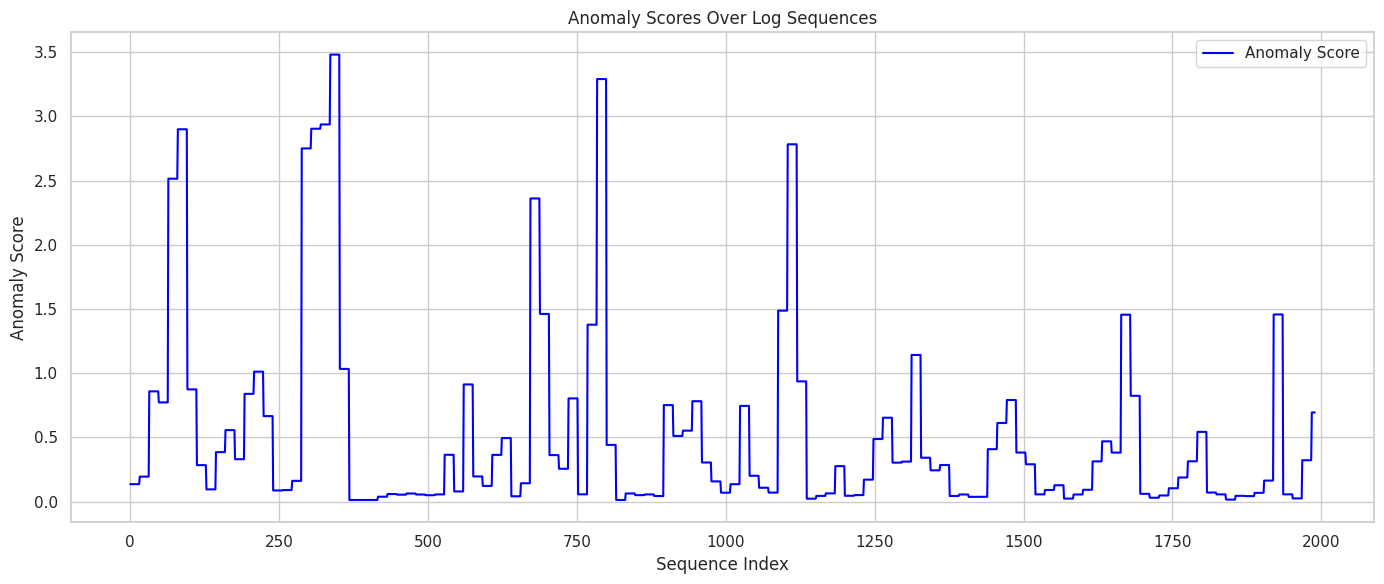

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved scores (if not already in memory)
csv_path = '/content/drive/MyDrive/logbert_anomaly_detection/results/anomaly_scores_with_flags.csv'
df = pd.read_csv(csv_path)

# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(14, 6))

# Line plot of anomaly scores
plt.plot(df['anomaly_score'], label='Anomaly Score', color='blue')
plt.title('Anomaly Scores Over Log Sequences')
plt.xlabel('Sequence Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.tight_layout()
plt.show()


**Highlight anomalies**

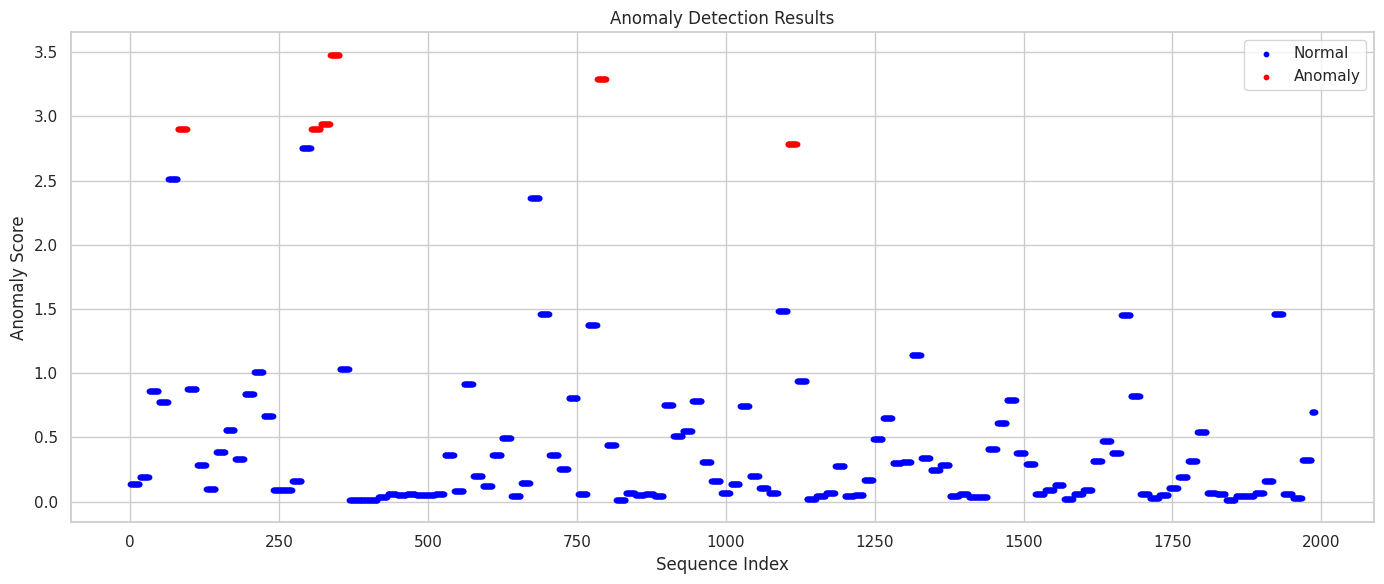

In [ ]:
# Scatter plot with anomalies highlighted
plt.figure(figsize=(14, 6))
normal = df[df['is_anomaly'] == False]
anomalies = df[df['is_anomaly'] == True]

plt.scatter(normal.index, normal['anomaly_score'], label='Normal', color='blue', s=10)
plt.scatter(anomalies.index, anomalies['anomaly_score'], label='Anomaly', color='red', s=10)
plt.title('Anomaly Detection Results')
plt.xlabel('Sequence Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.tight_layout()
plt.show()


**HIstogram of scores**

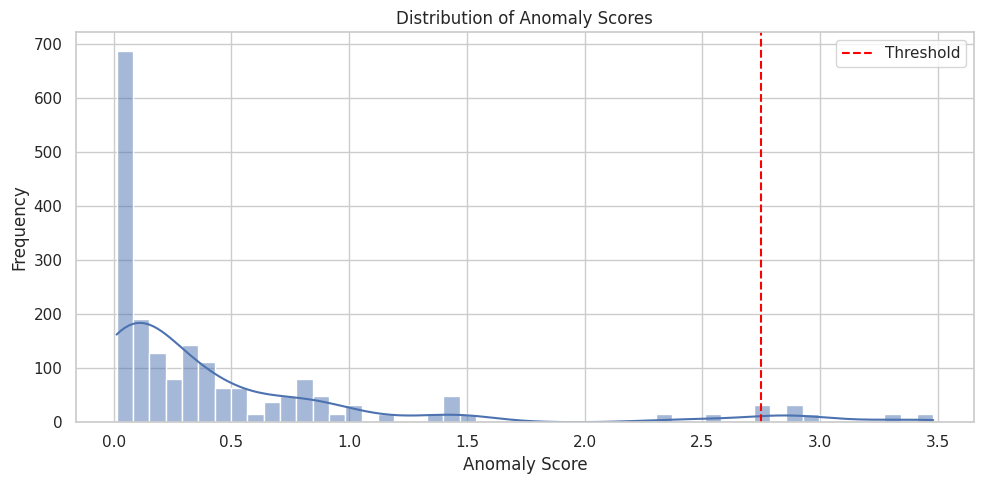

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['anomaly_score'], bins=50, kde=True)
plt.axvline(df['anomaly_score'].quantile(0.95), color='red', linestyle='--', label='Threshold')
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()
